In [6]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as fn

import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms

import os
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import VAE

In [14]:
import importlib
importlib.reload(VAE)
from VAE import VanillaVAE
from VAE import BaseVAE
from VAE import SaveBestModel


# importlib.reload(SaveBestModel)

In [13]:
# path = 'drive/MyDrive/ACBProj/ProcessedPerturbSeqData/'
# X = load_dataset(path)
path = './average_K562_essential_normalized_singlecell_combined.csv'
df = pd.read_csv(path)
# print(df.columns)
df = df.iloc[:,2:]
print(df.shape)

# os.listdir(path)

(8563, 2273)


In [9]:
from torch.utils import data

class RealDataset(data.Dataset):

  def __init__(self, X, y):
    # TODO: Your code here.
    self.features = X
    self.labels = y
    # pass
  
  def __getitem__(self, index):
    # TODO: Your code here.
    x = self.features[index]
    y = self.labels[index]
    return x,y
    # pass

  def __len__(self):
    # TODO: Your code here.
    return len(self.features)
    # pass



In [10]:
import torch
from torch import cuda
from scipy.stats import zscore

X = df.to_numpy()
xt = X.T
# xt = np.log1p(xt)


# xt = X[0].T
os.environ['CUDA_VISIBLE_DEVICES']='3'

if cuda.is_available():
  device = 'cuda'
else:
  print('WARNING: you are running this assignment on a cpu!')
  device = 'cpu'

# torch.cuda.set_device("cuda:")
print(torch.cuda.current_device())
A = torch.tensor(xt,device=device)
B = torch.tensor(xt,device = device)
# B = torch.tensor(test_npy, device=device)

trainDataset = RealDataset(A,A)
testDataset = RealDataset(B,B)

batch_size = 128
trainloader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=False)

testloader = data.DataLoader(testDataset, batch_size=batch_size, shuffle=False)
print(device)

0
cuda


In [15]:
x_dim = xt.shape[1]
hidden_dim = 100
print(x_dim,hidden_dim)
vae = VanillaVAE(x_dim,hidden_dim)
vae = vae.to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-4)
save_best_model = SaveBestModel()
model_path = "K563_phenotypes_VAE_alter_all_averaged.pth"

8563 100


In [7]:
ginny_pig = xt[0]
print(np.min(ginny_pig),np.max(ginny_pig))

pred,_,_,_ = vae(torch.tensor(ginny_pig,device=device).float())
pred = pred.detach().cpu().numpy()
print(np.min(pred),np.max(pred))

-1.77307194 1.76553086
-0.09192583 0.1071137


In [19]:
print(np.max(xt),np.min(xt))

42.2962878 -4.5307273


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print("Validation loss didn't increase much from {} for patience {}".format(self.min_validation_loss,self.counter))
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

earlystop = EarlyStopper(patience=30,min_delta=0.001)

In [ ]:
train_loss = []
test_loss = []
print_every = 5
for epoch in range(400):
  pcount = 0
  ncount = 0
  orpcount = 0
  orncount = 0
  vae.train()
  for x, _ in tqdm(trainloader):
    
    optimizer.zero_grad()
   
    # x = x
    x_pred, x_inp, mu, logvar = vae.forward(x.float())
    
    loss_dict = vae.loss_function(x_pred.float(), x_inp.float(), mu.float(), logvar.float())
    loss = loss_dict['loss']
    loss_dict['loss'].backward()
    optimizer.step()
  
  train_loss.append(loss_dict)
  
  
  vae.eval()
  for x,_ in tqdm(testloader):
    x_pred, x_inp, mu, logvar = vae(x.float())
    test_loss_dict = vae.loss_function(x_pred.float(), x_inp.float(), mu.float(), logvar.float())
   
  test_loss.append(test_loss_dict)
  save_best_model(
      test_loss_dict['loss'], epoch, vae, optimizer,vae.loss_function,model_path
  )

  if (epoch+1) % print_every == 0:
      print("[{}] Train Loss={}".format(epoch+1, loss_dict['loss']),"Reconstruction Loss={}".format(loss_dict['Reconstruction_Loss']),"KLD Loss={}".format(loss_dict['KLD']))
      print("[{}] Validation Loss={}".format(epoch+1, test_loss_dict['loss']),"Reconstruction Loss={}".format(test_loss_dict['Reconstruction_Loss']),"KLD Loss={}".format(test_loss_dict['KLD']))
      
  # if(earlystop.early_stop(test_loss[-1]['loss'].detach().cpu().numpy()) == True):
  #   break

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.03it/s]



Best validation loss: 0.047991883009672165

Saving best model for epoch: 1



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.93it/s]



Best validation loss: 0.046976495534181595

Saving best model for epoch: 2



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.56it/s]



Best validation loss: 0.046626314520835876

Saving best model for epoch: 3



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.05it/s]



Best validation loss: 0.04393000155687332

Saving best model for epoch: 4



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.00it/s]



Best validation loss: 0.04334067553281784

Saving best model for epoch: 5

[5] Train Loss=0.04360612481832504 Reconstruction Loss=0.04360612481832504 KLD Loss=-53.08762741088867
[5] Validation Loss=0.04334067553281784 Reconstruction Loss=0.04334067553281784 KLD Loss=-51.916114807128906


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.36it/s]



Best validation loss: 0.04302056133747101

Saving best model for epoch: 6



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.52it/s]



Best validation loss: 0.04268110170960426

Saving best model for epoch: 9



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.24it/s]


[10] Train Loss=0.04398765787482262 Reconstruction Loss=0.04398765787482262 KLD Loss=-68.89276885986328
[10] Validation Loss=0.04409599304199219 Reconstruction Loss=0.04409599304199219 KLD Loss=-68.8477554321289


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.34it/s]



Best validation loss: 0.042119819670915604

Saving best model for epoch: 11



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 57.70it/s]



Best validation loss: 0.041823312640190125

Saving best model for epoch: 13



100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 58.21it/s]



Best validation loss: 0.04177834466099739

Saving best model for epoch: 14



In [ ]:
def processLoss(item):
    item['loss'] = item['loss'].detach().cpu().numpy().tolist()
    item['Reconstruction_Loss'] = item['Reconstruction_Loss'].detach().cpu().numpy().tolist()
    item['KLD'] = item['KLD'].detach().cpu().numpy().tolist()
    return item

count = 0
for train,test in zip(train_loss,test_loss):
    
    # print(count,train,test)
    train_loss[count] = processLoss(train)
    test_loss[count] = processLoss(test)
    count +=1

# print(train_loss,test_loss)
import json
with open('trainLossK562', 'w') as fout:
    json.dump(train_loss, fout)
    
with open('testLossK562', 'w') as fout:
    json.dump(test_loss, fout)

1000 1000


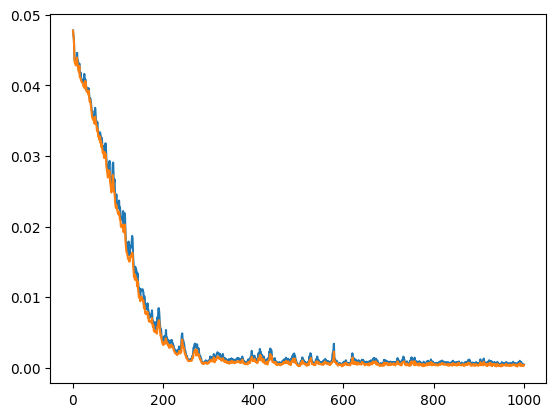

In [18]:
print(len(train_loss),len(test_loss))
plt.plot(range(1,len(train_loss)+1),train_loss)
plt.plot(range(1,len(test_loss)+1),test_loss)
plt.show()

In [29]:
model = vae
path = 'k562.pth'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_loss[epoch],
    }, path)

In [11]:
from torchsummary import summary
summary(vae,input_size=xt.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 2273, 4281]      36,662,484
         LeakyReLU-2           [-1, 2273, 4281]               0
            Linear-3           [-1, 2273, 2140]       9,163,480
         LeakyReLU-4           [-1, 2273, 2140]               0
            Linear-5           [-1, 2273, 1070]       2,290,870
         LeakyReLU-6           [-1, 2273, 1070]               0
            Linear-7            [-1, 2273, 535]         572,985
         LeakyReLU-8            [-1, 2273, 535]               0
            Linear-9            [-1, 2273, 267]         143,112
        LeakyReLU-10            [-1, 2273, 267]               0
           Linear-11            [-1, 2273, 100]          26,800
           Linear-12            [-1, 2273, 100]          26,800
           Linear-13            [-1, 2273, 267]          26,967
           Linear-14            [-1, 22

# Inference

In [ ]:
import torch
from torch import cuda

if cuda.is_available():
  device = 'cuda'
else:
  print('WARNING: you are running on a cpu!')
  device = 'cpu'

xt = X[0].T
print(xt.shape)
A = torch.tensor(xt,device=device)
# trainDataset = RealDataset(A,A)

batch_size = 16
# trainloader = data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

# model_path = "drive/MyDrive/ACBProj/VAE_Models/real_dataset_new_hiddSize_10.pth"

x_dim = xt.shape[1]
# hidden_dim = 10
vae = VanillaVAE(x_dim,hidden_dim).cuda()
vae_inf = VanillaVAE(x_dim,hidden_dim)
vae_inf.load_state_dict(torch.load(model_path)['model_state_dict'])

vae_inf = vae_inf.to(device)

(2273, 8563)


In [19]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA 
import seaborn as sns
import math
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

vae_inf = vae

@torch.no_grad()
def inference(A):
  A = A.to(device)
  # vae_inf = vae_inf.to(device)
  x_pred, x, mu, logvar = vae_inf(A.float())
  std = torch.exp(0.5 * logvar)
  epilson = torch.rand_like(std)
  z_vec = std * epilson + mu
  # print(mu.shape)
  return z_vec,mu


z_vec,mu = inference(A)
# print(mean.shape)
z_vec = z_vec.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()

#TSNE


In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1,n_iter=5000)
res = tsne.fit_transform(z_vec)

/home/ssawmya/anaconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ssawmya/anaconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2273 samples in 0.000s...
[t-SNE] Computed neighbors for 2273 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2273
[t-SNE] Computed conditional probabilities for sample 2000 / 2273
[t-SNE] Computed conditional probabilities for sample 2273 / 2273
[t-SNE] Mean sigma: 1.787550
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.325302
[t-SNE] KL divergence after 3200 iterations: 2.508595


In [21]:
def plot_clusters(df,labels):
  #Getting unique labels
  # print(df.shape)
  df['labels'] = labels 
  u_labels = np.unique(labels)
  
  #plotting the results:
  
  for i in u_labels:
      plt.scatter(df.values[labels == i , 0] , df.values[labels == i , 1])
  plt.legend()
  plt.show()

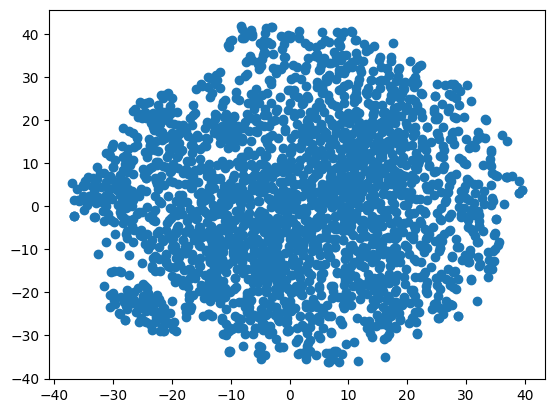

In [27]:
plt.scatter(res[:,0],res[:,1])
# kmeans = KMeans(n_clusters= 6)
 
# #predict the labels of clusters.
# label = kmeans.fit_predict(res)

# np.unique(label,return_counts=True)
# df1 = pd.DataFrame(data = res,
#                  columns = ["Component 1",
#                             "Component 2"])


# plt.title("Latent Dim = 100, K = 6")
# plot_clusters(df1,label)

#PyMDE


Dec 09 12:59:42 PM: Computing 11-nearest neighbors, with max_distance=None
Dec 09 12:59:42 PM: Exact nearest neighbors by brute force 
Dec 09 12:59:42 PM: Computing quadratic initialization.


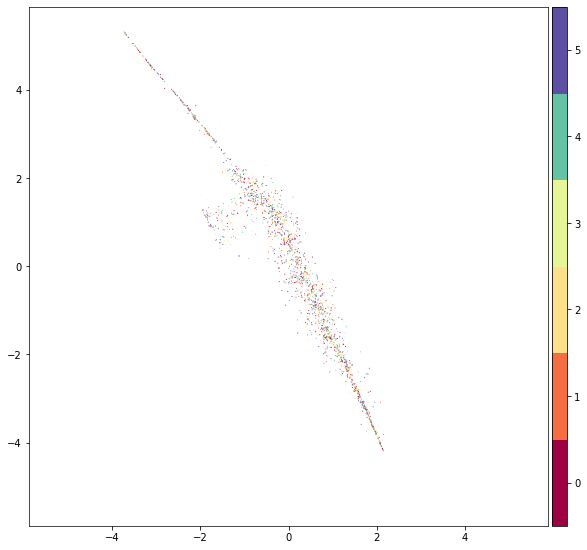

In [ ]:
# !pip install pymde
import pymde
embedding = pymde.preserve_neighbors(mu, embedding_dim=2, verbose=True).embed()
pymde.plot(embedding,color_by=label)

# Elbow

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(mu)
    kmeanModel.fit(mu)
  
    distortions.append(sum(np.min(cdist(z_vec, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / z_vec.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(z_vec, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / z_vec.shape[0]
    mapping2[k] = kmeanModel.inertia_

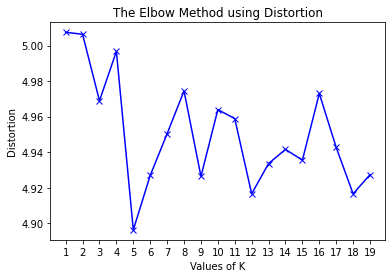

In [ ]:
plt.plot(K[:50], distortions[:50], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.xticks(range(1,20))
plt.title('The Elbow Method using Distortion')
plt.show()

# Clusters


In [ ]:
#Initialize the class object
labels = {}
for n_clust in range(2,100):
  kmeans = KMeans(n_clusters= n_clust)
  
  #predict the labels of clusters.
  label = kmeans.fit_predict(mu)
  cluster_ = "Clusters_{}".format(n_clust)
  labels[cluster_] = label
  # np.unique(label,return_counts=True)
  # plot_clusters(df,label)


In [ ]:
Target = "Phenotype"
cluster_directory =  'drive/MyDrive/ACBProj/Cluster/{}'.format(Target)

dictionary = labels
np.save('{}/cluster_labels_rpe1_upto_100.npy'.format(cluster_directory), dictionary) 

# Load
read_dictionary = np.load('{}/cluster_labels_rpe1_upto_100.npy'.format(cluster_directory),allow_pickle='TRUE').item()
print(np.unique(read_dictionary['Clusters_12'])) # displays "world"

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
input_data = pd.read_csv('drive/MyDrive/ACBProj/ProcessedPerturbSeqData/average_RPE1_essential_normalized_singlecell_fold_0.csv')
read_dictionary['Phenotype'] = list(input_data.iloc[:,1:].columns)
# read_dictionary['Genotype'] = list(input_data['gene_id'])

df = pd.DataFrame.from_dict(read_dictionary)
# print(df.columns)
cols = list(df)
cols.insert(0, cols.pop(cols.index('Phenotype')))
df = df.loc[:, cols]
df.to_csv("{}/ClustersUpto100_Phenotype.csv".format(cluster_directory),index=False)